## Homework 7
- Goal: Train a deep learning neural network to classify insects images.
- Basic model structure
    - 3x3 convolution -> 3x3 convolution -> 2x2 max pool
    - 3x3 convolution -> 3x3 convolution -> 2x2 max pool
    - fully connected layer: 256 units
    - fully connected layer: 3 units (prediction class)
- Outcome
    - The accuracy on the test dataset is 87.2%.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
import time

In [2]:
transform = transforms.Compose([transforms.Resize((320,384)),
                                transforms.ToTensor()])

In [3]:
insect_train = datasets.ImageFolder('E:/Graduate_year_2/BIOS823/BIOS823HW/insects/insects/train/', transform=transform)

In [4]:
print('Number of samples: ', len(insect_train))

Number of samples:  1019


In [5]:
img, target = insect_train[13]
print('image size: ', img.size())

image size:  torch.Size([3, 320, 384])


In [6]:
insect_test = datasets.ImageFolder('E:/Graduate_year_2/BIOS823/BIOS823HW/insects/insects/test/', transform=transform)

In [7]:
print('Number of samples: ', len(insect_test))

Number of samples:  180


In [8]:
train_loader = torch.utils.data.DataLoader(insect_train, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(insect_test, batch_size =16, shuffle=True)

In [10]:
class INSECT_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(80*96*64, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        
        # conv layer 4
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # fc layer 1
        x = x.view(-1, 80*96*64)
        x = self.fc1(x)
        x = F.relu(x)
        
        # fc layer 2
        x = self.fc2(x)
        return x    

In [11]:
model = INSECT_CNN()

In [16]:
print(model)

INSECT_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=491520, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Iterate through train set minibatchs 
for epoch in trange(3):  # <---- change here
    for images, labels in tqdm(train_loader):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = images  # <---- change here 
        y = model(x)
        loss = criterion(y, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

In [14]:
## Testing
correct = 0
total = len(insect_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images  # <---- change here 
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.8722222447395325


In [17]:
print('Test accuracy: {}'.format(correct/total))

Test accuracy: 0.8722222447395325


## Transfer Learning: Finetuning the convnet

In [14]:
import torchvision.models as models
#resnet18 = models.resnet18()
#print(resnet18)

In [2]:
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = 'insects/insects/'

In [5]:
import os

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [22]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [23]:
dataset_sizes

{'train': 1019, 'test': 180}

In [8]:
class_names = image_datasets['train'].classes
class_names

['beetles', 'cockroach', 'dragonflies']

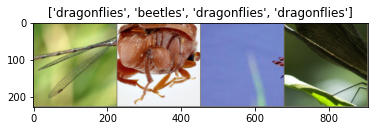

In [9]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(pretrained=True)

In [16]:
num_ftrs = model_ft.fc.in_features

In [18]:
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

In [42]:
device = torch.device("cpu")

In [43]:
device

device(type='cpu')

In [44]:
model_ft = model_ft.to(device)

In [20]:
import copy

In [25]:
import torchvision

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False #we do not retrain the weights except for the last layer

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3) #Here, we have 3 classes

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6495 Acc: 0.7213
test Loss: 0.2163 Acc: 0.9278

Epoch 1/24
----------
train Loss: 0.5407 Acc: 0.7890
test Loss: 0.2109 Acc: 0.9333

Epoch 2/24
----------
train Loss: 0.4326 Acc: 0.8381
test Loss: 0.1363 Acc: 0.9167

Epoch 3/24
----------
train Loss: 0.4614 Acc: 0.8243
test Loss: 0.0774 Acc: 0.9667

Epoch 4/24
----------
train Loss: 0.4411 Acc: 0.8361
test Loss: 0.0882 Acc: 0.9556

Epoch 5/24
----------
train Loss: 0.3986 Acc: 0.8489
test Loss: 0.1768 Acc: 0.9556

Epoch 6/24
----------
train Loss: 0.4501 Acc: 0.8371
test Loss: 0.1431 Acc: 0.9222

Epoch 7/24
----------
train Loss: 0.3580 Acc: 0.8754
test Loss: 0.1051 Acc: 0.9667

Epoch 8/24
----------
train Loss: 0.3764 Acc: 0.8577
test Loss: 0.1066 Acc: 0.9667

Epoch 9/24
----------
train Loss: 0.3604 Acc: 0.8597
test Loss: 0.0953 Acc: 0.9778

Epoch 10/24
----------
train Loss: 0.3564 Acc: 0.8714
test Loss: 0.0983 Acc: 0.9722

Epoch 11/24
----------
train Loss: 0.3270 Acc: 0.8646
test Loss: 0.1009 Acc

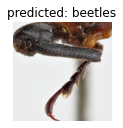

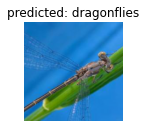

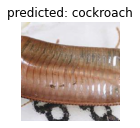

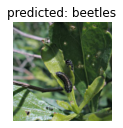

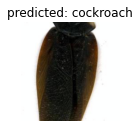

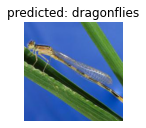

In [28]:
visualize_model(model_conv)

plt.ioff()
plt.show()